## Reinforcement Learning - Aoudia and Hoydis
##### Imports

In [23]:
import tensorflow as tf
import keras 
import numpy as np
from keras.layers import Input, Dense, Lambda, ELU, Reshape
from keras.models import Model
from keras.layers.normalization import BatchNormalization 
from keras import backend as K
from keras.layers import GaussianNoise, advanced_activations
from keras.engine.topology import Layer
from keras.legacy import interfaces
from keras.initializers import Zeros as kZeros
from keras.utils import multi_gpu_model
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from keras.callbacks import EarlyStopping, History, ModelCheckpoint
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from time import time
import pickle
import multiprocessing

In [24]:
# # confirm TensorFlow sees the GPU
# from tensorflow.python.client import device_lib
# assert 'GPU' in str(device_lib.list_local_devices())

# # confirm Keras sees the GPU
# from keras import backend
# assert len(backend.tensorflow_backend._get_available_gpus()) > 0

In [25]:
# # This is in a seperate box because it isn't running on the 
# # AWS server. 
# from tqdm import tqdm_notebook, tnrange
# from joblib import Parallel, delayed

##### Useful guides
https://hub.packtpub.com/build-reinforcement-learning-agent-in-keras-tutorial/
<br>
https://medium.com/ml-everything/policy-based-reinforcement-learning-with-keras-4996015a0b1
<br>

##### Notes from paper
- Loss function = Cross Entropy
- Normalisation = Average L2 power constraint = 1. $\mathbb{E}\left[\frac{1}{N}\left\Vert x\right\Vert_2^2\right]$ = 1.
- Trained at an SNR of 10dB for AWGN and an SNR of 20dB for RBF channel. $\sigma_{\pi}^2$ = 0.02 at training time.
    - During RL exploration $\mathbf{x_p} = \mathbf{x} + \mathbf{w}$, where each element of $\mathbf{w}$ is i.i.d ~ $\mathcal{N}(0,\sigma_{\pi}^2)$
- M= 256, N=4. N= the number of complex channel uses, so n = 8. Therefore n,k = (8,8)
- AWGN -> 1 hidden layer, size M, ReLu activation function
- Rayleigh -> see diagram.
    - Two layers (Dense(20,tanh)->Dense(2,linear)) calculate an estimate for $\hat{h}$, then we divide the received signal by $\hat{h}$ then have two layers for finding the received signal. Dense(M,ReLu) then Dense(M,Softmax). Then have the select maximum likelihood symbol layer.
- SNR $ = \frac{\mathbb{E}\left[\frac{1}{N}\left\Vert x\right\Vert_2^2\right]}{\sigma^2}$, but because of the normalisation this is $\frac{1}{\sigma^2}$.
- The RBF seems to be slow fading, but I could check for fast fading as well. Rayleigh fading is of the form $\mathbf{r} = \mathbf{s}*\mathbf{h} + \mathbf{n}$ where $\mathbf{h}$ ~ $\mathcal{N}(0,\sigma_m^2)$, $\mathbf{n}$ ~ $\mathcal{N}(0,\sigma_a^2)$. 
    - Slow fading: h stays the same across the whole minibatch
    - Fast fading: h changes every sample
- I'm going to guess that $\sigma_m ~ \frac{1}{3}$. Because this means that 98% of the time it's less than 1. Which sounds alright.
- I could also try Ricean fading and see how the model performs against that.
- Ricean fading would actually be the most general, as then it could learn Rayleigh fading, and it could also learn AWGN just by learning to make $\hat{h}$ every time.

##### Work Log

27/05/2019
- Started researching RBF, think I can implement it in a custom layer.
- Made lots of notes
- Copied over functions from other notebook.

28/05/2019
- Made functions for making the Tx and Rx blocks for the unsupervised learning, however these will likely need to be edited.


29/05/2019
- Got food poisoning the night before and did no work.

31/05/2019
- Got the rbf supervised model fitting, but with no good results. 
- Copied the architecture from the paper exactly, however it was not effective. This involved:
    - Adding layers for complex multiplication and division.
    - Adding layers for seperately finding the $\hat{h}$ as an expert feature.
    - Adding a custom layer that added rbf fast fading 
- Initially I set the $sigma_m$ to 0.33, for the reasons laid out above, but the model wasn't making any progress training. So after some research I found it written online somewhere that it is often set to $\frac{1}{\sqrt{2}}$ to give unity fading gain on average. This seems wrong as you should expect to lose power in the channel. However, upon trying this the model trained vastly more successfully so I may stick with this, or train at a higher SNR if I don't use this.
- Going to try debugging it for a while, then I may try using different numbers of layers and activation functions to try and get the two supervised lines in Figures 6a and 6b from the Aoudia and Hoydis paper. After this I can try and get the reinforcement learned lines giving the same results. 

03/06/2019
- Converting the interim report into the introduction and background sections of the final report. Also writing the abstract.

04/06/2019
- Fixed the average power normalisation
- Continued converting the interim report into the start of a final report.
- Found that the model had very significant gains if I trained it with $sigma_a = 0$, investigating whether this could be an effective way of training the $\hat{h}$ estimation section of the model more quickly so it could then go on to learning the additive noise section later. However this is not how it would be able to work in a normal channel.
    - On this subject it was found that the model hardly learnt anything in an RBF channel at 20db of SNR. So 40db was trialled which was more successful, but still trained extremely slowly. This is how no noise was trielled, which gave extremely fast reduction of validation loss.
    
05/06/2019
- Got supervised AWGN graph for a range of SNRs.
- Converted interim report into the first two sections of the final report. Adapted Implementation Plan, Evaluation Plan sections and moved Safety, Ethical and Legal plan into the appendix.
- Trained supervised_rbf_sa40 for 100 epochs locally.

06/06/2019
- Added parallel for using joblib for the sweeping across SNRs

##### To do
- Try running the best supervised_rbf_sa40 model over a range of SNRs to see what kind of curve it gives.
- Investigate BCH codes, see how long I think it would take to implement one. 
- Look at a t-SNE reduced constellation diagram for the supervised_rbf_sa40 model to try and see if it has multiple symbols converging to single points.

### Function Definitions

In [26]:
def most_likely(posterior_probs):
    max_vals = K.max(posterior_probs, axis=1, keepdims=True) 
    max_vals = K.cast(max_vals, 'float32')
    geT = K.greater_equal(posterior_probs, max_vals)
    return K.cast(geT, 'float32')

In [27]:
def get_noise_sigma(Eb_N0_db, Rr=None, Rc=None):
    assert(not((Rr == None)&(Rc == None)))
    if(Rr == None):
        Rr = Rc/2.
    Eb_N0 = 10.**(Eb_N0_db/10.)
    return np.sqrt(1./(2.*Rr*Eb_N0))

In [28]:
def get_data_set(M, total_size):
    t0 = time()
    all_one_hot_messages = np.diag(np.ones(M))
    perc_train = 0.75
    perc_valid = 0.1

    ## Making Data Set
    multiple = total_size//M
    diff = total_size - (multiple * M)

    ## Get quotient 
    ## Converted the array into a list because it is significantly
    ## faster
    l = []
    all_one_hot_messages_lst = all_one_hot_messages.tolist()
    for mult in range(multiple):
        for i in range(M):
            l.append([all_one_hot_messages_lst[i]])
    data = np.concatenate(l)

    # Add remainder
    random_inds = np.random.choice(np.arange(M),size=diff, replace=False)
    extra_rows = all_one_hot_messages[random_inds,:]
    data = np.concatenate((data, extra_rows), axis=0)
    np.random.shuffle(data)
    file_path = "./data/data"+str(M)+".npy"
    np.save(file_path, data)
    print(f"Took {time() - t0}s")
    return data, file_path, all_one_hot_messages

In [29]:
class MostLikelySymbol(Layer):
    """Return the most likely symbol from a softmax input in the
    one hot encoded form.

    This layer is only active at test time as otherwise it would
    stop gradient propogation during training. Also it is useful
    to train with a softmax output to encourage a decisive 
    decision and because it means you can assess confidence.

    # Arguments
        None

    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.

    # Output shape
        Same shape as input.
    """

    @interfaces.legacy_gaussiannoise_support
    def __init__(self, **kwargs):
        super(MostLikelySymbol, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs, training=None):
        def most_likely():
            max_vals = K.max(inputs, axis=1, keepdims=True) 
            max_vals = K.cast(max_vals, 'float32')
            geT = K.greater_equal(inputs, max_vals)
            return K.cast(geT, 'float32')            
        return K.in_train_phase(inputs, most_likely, training=training)

    def get_config(self):
        config = {}
        base_config = super(MostLikelySymbol, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [30]:
class GaussianNoise2(Layer):
    """Apply additive zero-centered Gaussian noise at both traning
    and test time.

    This is useful to mitigate overfitting
    (you could see it as a form of random data augmentation).
    Gaussian Noise (GS) is a natural choice as corruption process
    for real valued inputs.

    Unlike the built in GaussianNoise regularisation layer it is 
    active at both training and test time. 

    # Arguments
        stddev: float, standard deviation of the noise distribution.

    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.

    # Output shape
        Same shape as input.
    """

    @interfaces.legacy_gaussiannoise_support
    def __init__(self, stddev, **kwargs):
        super(GaussianNoise2, self).__init__(**kwargs)
        self.supports_masking = True
        self.stddev = stddev

    def call(self, inputs, training=None):
        def noised():
            return inputs + K.random_normal(shape=K.shape(inputs),
                                            mean=0.,
                                            stddev=self.stddev)
        return K.in_train_phase(noised, noised, training=training)

    def get_config(self):
        config = {'stddev': self.stddev}
        base_config = super(GaussianNoise2, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [31]:
class RayleighBlockFading_fast(Layer):
    """
    Applies Rayleigh Block (fast) Fading to the input data at both 
    training and test time.

    # Arguments
        sigma_m: float, standard deviation of the multiplicative 
        constant noise distribution.
        sigma_a: float, standard deviation of the additive 
        constant noise distribution.

    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.

    # Output shape
        Same shape as input.
    """

    def __init__(self, sigma_m, sigma_a, **kwargs):
        super(RayleighBlockFading_fast, self).__init__(**kwargs)
        self.supports_masking = True
        self.sigma_m = sigma_m
        self.sigma_a = sigma_a

    def call(self, inputs, training=None):   
        def custom_mult(in_,col_sel,h):
            tmp = K.tf.multiply(col_sel,h)
            tmp_expand = K.expand_dims(tmp,axis=1)
            return K.tf.multiply(in_,tmp_expand)
        def complex_mult(in_,h):
            o1 = K.constant(np.array([1,0]))
            o2 = K.constant(np.array([0,1]))
            h_swap = K.tf.reverse(h,[1])
            in_swap = K.tf.reverse(in_,[2])

            t1 = custom_mult(in_,o1,h)          # real*real
            t2 = custom_mult(in_swap,o1,h_swap) # imaginary*imaginary
            t3 = custom_mult(in_swap,o2,h)      # real*imaginary
            t4 = custom_mult(in_,o2,h_swap)     # imaginary*real

            total1 = K.tf.math.subtract(t1,t2)  # r1*r2-i1*i2
            total2 = K.tf.math.add(t3,t4)       # r1*i2 + i1*r2
            return K.tf.math.add(total1,total2) # r1*r2-i1*i2 + r1*i2 + i1*r2
        def RBF_fade():
            hT = K.random_normal(shape=(K.shape(inputs)[0],K.shape(inputs)[2]),
                                 mean=0.,
                                 stddev=self.sigma_m)
            nT = K.random_normal(shape=K.shape(inputs),
                                 mean=0.,
                                 stddev=self.sigma_a)
            return K.tf.add(complex_mult(inputs,hT),nT)
        return K.in_train_phase(RBF_fade, RBF_fade, training=training)

    def get_config(self):
        config = {'sigma_m': self.sigma_m, 'sigma_a': self.sigma_a}
        base_config = super(RayleighBlockFading_fast, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [32]:
def get_layer_shapes(start, end, num_steps):
    shapes = [start]
    diff = (end-start)/(num_steps-1)
    # Always start with a full dense layer
    for i in range(1,num_steps):
        shapes.append(int(start + i*diff))
    return shapes

In [33]:
def make_complex_n_layer_lr_tanh_tapering_model(M, R, sigma, \
                                                hl_activation_func, \
                                                ol_activation_func, \
                                                num_layers):
    ### Initialising Parameters
    k = np.log2(M) # Number of bits needed to represent M 
                   # messages
    Nc = int(round(k/R)) # Number of bit being used to represent
                        # channel symbols being used 
                        # Number of complex channel uses
    Nr = Nc*2 # Number of real channel uses

    ### Defining Layers
    ## TRANSMITTER
    tx_shapes = get_layer_shapes(M, Nr, num_layers)
    input_message = Input(shape=(M,), name="input")
    # Hidden Tx layers
    tx1 = Dense(tx_shapes[0],activation=hl_activation_func, \
                name="tx1")(input_message)
    for i in range(1,num_layers-1):
        tx1 = Dense(tx_shapes[i],activation=hl_activation_func, \
                    name=("tx"+str(i+1)))(tx1)
    # Final layer with a different activation function to capture non
    # linearity
    tx_n = Dense(tx_shapes[-1],activation=ol_activation_func, \
                 name=("tx"+str(num_layers)))(tx1)
    # Reshape it to complex channel symbols
    tx_complex = Lambda(lambda x : K.reshape(x, (-1,Nc,2)),
                       output_shape=(Nc,2), \
                        name="tx_reshape")(tx_n)

    # Normalisation Layer
    tx_norm = Lambda(lambda x : K.l2_normalize(x,axis=2),
                     output_shape=(Nc,2), name="tx_norm")\
                        (tx_complex)
    tx_norm_scaled = Lambda(lambda x : K.tf.multiply(np.float32(np.sqrt(Nr)), x),
                      output_shape=(Nr,), name="tx_norm_scaled")\
                        (tx_norm)
    
    # Add Noise 
    noise = GaussianNoise2(sigma)(tx_norm_scaled)

    ## RECIEVER
    # Flatten the input
    noise_flat = Lambda(lambda x : K.reshape(x, (-1,Nr)),
                       output_shape=(Nr,),\
                        name="noise_flat")(noise)
    # First layer with the different activation function
    # to capture non-linearity and for symmetry with the 
    # transmitter.
    rx1 = Dense(tx_shapes[-2],activation=ol_activation_func, name="rx1")\
                (noise_flat)
    # Hidden Rx Layers
    if(num_layers >= 3):
        layer_ind = -3
    else:
        layer_ind = -2
    rx_i = Dense(tx_shapes[layer_ind],activation=hl_activation_func, \
                name="rx2")(rx1)
    for i in range(2,num_layers):
        ind = max(0,num_layers - 2 - i)
        rx_i = Dense(tx_shapes[ind],activation=hl_activation_func, \
                    name=("rx"+str(i+1)))(rx_i)
    # Dense layer with softmax activation
    rx_softmax = Dense(tx_shapes[0],activation='softmax', \
                       name="rx_softmax")(rx_i)
    
    # Select the symbols with the maximum probabilities
    ml_symbs = MostLikelySymbol()(rx_softmax)
    
    ###Defining the models
    autoencoder = Model(input_message, rx_softmax)
    ## Model the Tx and Rx seperately as well
    # Model the Tx
    transmitter = Model(input_message, tx_norm_scaled)
    # Model the Tx plus the noise
    channel_sym_with_noise = Model(input_message, noise)
    channel_symbol = Input(shape=(Nr,))
    # Take the last layer of the autoencoder model
    reciever_layers = autoencoder.layers[-(num_layers+1)](channel_symbol)
    for i in range(num_layers):
        reciever_layers = autoencoder.layers[-(num_layers-i)](reciever_layers)

    # Create a model of the reciever
    reciever = Model(channel_symbol, reciever_layers)
    autoencoder_symbs = Model(input_message,ml_symbs) 
    
    # Compile the model
    autoencoder.compile(loss='categorical_crossentropy',
                        optimizer="adam")
    return autoencoder, transmitter, reciever,\
            autoencoder_symbs, k, Nc, Nr

In [34]:
def custom_mult(in_,col_sel,h):
    tmp = K.tf.multiply(col_sel,h)
    tmp_expand = K.expand_dims(tmp,axis=1)
    return K.tf.multiply(in_,tmp_expand)

def complex_div(in_lst):
    in_,h = in_lst
    o1 = K.constant(np.array([1,0]))
    o2 = K.constant(np.array([0,1]))
    h_swap = K.tf.reverse(h,[1])
    in_swap = K.tf.reverse(in_,[2])

    t1 = custom_mult(in_,o1,h)          # real*real
    t2 = custom_mult(in_swap,o1,h_swap) # imaginary*imaginary
    t3 = custom_mult(in_swap,o2,h)      # real*imaginary
    t4 = custom_mult(in_,o2,h_swap)     # imaginary*real

    total1 = K.tf.math.add(t1,t2)        # xr*hr-xi*hi
    total2 = K.tf.math.subtract(t4,t3)   # xr*hi-xi*hr
    total = K.tf.math.add(total1,total2) # xr*hr+xi*hi + xr*hi-xi*hr

    scale_factor = K.sum(K.tf.math.square(h), axis=1) # hr^2 + hi^2
    scale_factor_expanded_twice = K.expand_dims(K.expand_dims(scale_factor, axis=1), axis=2)
    return K.tf.math.divide(total,scale_factor_expanded_twice) 

def complex_mult(in_,h):
    o1 = K.constant(np.array([1,0]))
    o2 = K.constant(np.array([0,1]))
    h_swap = K.tf.reverse(h,[1])
    in_swap = K.tf.reverse(in_,[2])

    t1 = custom_mult(in_,o1,h)          # real*real
    t2 = custom_mult(in_swap,o1,h_swap) # imaginary*imaginary
    t3 = custom_mult(in_swap,o2,h)      # real*imaginary
    t4 = custom_mult(in_,o2,h_swap)     # imaginary*real

    total1 = K.tf.math.subtract(t1,t2)  # r1*r2-i1*i2
    total2 = K.tf.math.add(t3,t4)       # r1*i2 + i1*r2
    return K.tf.math.add(total1,total2) # r1*r2-i1*i2 + r1*i2 + i1*r2

sigma_m = 0.33
sigma_a = 1

def RBF_fade(in_, sigma_m, sigma_a):
    hT = K.random_normal(shape=(K.shape(in_)[0],K.shape(in_)[2]),
                         mean=0.,
                         stddev=sigma_m)
    nT = K.random_normal(shape=K.shape(in_),
                         mean=0.,
                         stddev=sigma_a)
    return K.tf.add(complex_mult(in_,hT),nT)

In [35]:
def get_num_elements(tensor):
    dim_lst = tensor.get_shape().as_list()
    num_elements = 1
    for dim in dim_lst:
        if(dim != None):
            num_elements *= dim
    return num_elements

def get_avg_power(signal):
    # Gets the power according to the definition 
    # on the top of the fraction in Eq 8 the
    # Aoudia and Hoydis paper.
    assert(len(signal.shape) == 3)
    num_elements = get_num_elements(signal)
    sq = K.tf.math.square(signal)
    sq_sum_all = K.sum(K.sum(K.sum(sq,axis=2),axis=1),axis=0)
    return K.tf.math.divide(sq_sum_all,K.tf.dtypes.cast(num_elements,tf.float32))

def avg_power_normalise(signal):
    avg_power = get_avg_power(signal)
    return K.tf.math.divide(signal,K.tf.math.sqrt(avg_power))
#     return K.tf.math.divide(signal,avg_power)

In [36]:
# average power constraint layer
B = 1000000
Nc = 4
tx_T = K.constant(np.random.normal(0,2,(B,Nc,2)))
sess = tf.Session()
with sess.as_default():
    tx_T.eval(session=sess)
# tx_T.eval(session=sess)
get_avg_power(avg_power_normalise(tx_T)).eval(session=sess)

1.0

In [37]:
get_avg_power(K.constant(np.array([[[0,1,2]]]))).eval(session=sess)

1.6666666

AWGN alternating model has a single dense ReLu layer, I'm going to use the topology I found to be best in the other notebook, two layers, tapered 

In [38]:
def get_rbf_autoencoder(k, Nc, sigma_m, sigma_a):
#     k = np.log2(M) # Number of bits needed to represent M 
#                    # messages
    M = 2**k
    Nr = Nc*2 # Number of real channel uses
    
    ### Defining Layers
    ## TRANSMITTER
    tx_input_message = Input(shape=(M,), name="input")
    tx1 = keras.layers.Embedding(M, M, name="embedding")(tx_input_message)
    tx1 = keras.layers.ELU(alpha=1.0, name="embed_ELU")(tx1)
    # Reshape it to complex channel symbols
    tx_flat = Reshape((M*M,), name="post_embed_flatten")(tx1)  
    tx2 = Dense(Nr,activation="linear", name="tx2")(tx_flat)
    # Reshape it to complex channel symbols
    tx_complex = Reshape((Nc,2), name="tx_reshape")(tx2)
    # Normalisation Layer
    tx_norm = Lambda(lambda x : avg_power_normalise(x),
                     output_shape=(Nc,2), name="tx_norm")\
                    (tx_complex)
    tx_norm_scaled = Lambda(lambda x : K.tf.multiply(np.float32(np.sqrt(32)), x),
                      output_shape=(Nc,2), name="tx_norm_scaled")\
                        (tx_norm)
    # Add AWGN Noise 
    noise = RayleighBlockFading_fast(sigma_m,sigma_a)(tx_norm)

    ## receiver
    # Flatten the input
    noise_flat = Reshape((Nr,), name="noise_flat")(noise)
    # First layer with the different activation function
    # to capture non-linearity and for symmetry with the 
    # transmitter.
    h1 = Dense(20,activation="tanh", name="h1")\
                (noise_flat)
    h_hat = Dense(2,activation="linear", name="h_hat")\
                (h1)
    y_over_h = Lambda(lambda x : complex_div(x),
                      output_shape=(Nc,2),\
                      name="y_over_h")([noise, h_hat])
    y_over_h_flat = Reshape((Nr,), name="y_over_h_flat")(y_over_h)
    rx1 = Dense(M,activation="relu", name="rx1")\
                (y_over_h_flat)
    # Dense layer with softmax activation
    rx_softmax = Dense(M,activation='softmax', \
                       name="rx_softmax")(rx1)
    # Select the symbols with the maximum probabilities
    ml_symbs = MostLikelySymbol()(rx_softmax)

    ###Defining the models
    # Model the Tx
    autoencoder = Model(tx_input_message, rx_softmax)
    autoencoder_symbs = Model(tx_input_message,ml_symbs) 
    transmitter = Model(tx_input_message, tx_norm_scaled)
    # Model the Tx plus the noise
    channel_sym_with_noise = Model(tx_input_message, noise)
    # Model the Rx
    channel_symbol = Input(shape=(Nc,2), name="rx_in")
    num_layers = 8
    receiver_layers = autoencoder.layers[-num_layers](channel_symbol)
    for i in range(3):
        receiver_layers = autoencoder.layers[-(num_layers-1-i)](receiver_layers)
    receiver_layers = autoencoder.layers[-(num_layers-4)]([channel_symbol,receiver_layers])
    for i in range(4,num_layers-1):
        receiver_layers = autoencoder.layers[-(num_layers-1-i)](receiver_layers)
    # Create a model of the receiver
    receiver = Model(channel_symbol, receiver_layers)
    # Compile the model
    autoencoder.compile(loss='categorical_crossentropy',
                        optimizer="adam")

    return autoencoder, autoencoder_symbs, transmitter, \
        channel_sym_with_noise, receiver

In [39]:
def get_rbf_autoencoder_custom(k, Nc, sigma_m, sigma_a, \
                               num_layers, tx_activation_func, \
                               rx_activation_func, rx_end_activation_func):
#     k = np.log2(M) # Number of bits needed to represent M 
#                    # messages
    M = 2**k
    Nr = Nc*2 # Number of real channel uses
    
    ### Defining Layers
    ## TRANSMITTER
    # ELU layer captures non-linearity
    tx_input_message = Input(shape=(M,), name="input")
    tx1 = keras.layers.Embedding(M, M, name="embedding")(tx_input_message)
    tx1 = keras.layers.ELU(alpha=1.0, name="embed_ELU")(tx1)
    # Reshape it to complex channel symbols
    tx_flat = Reshape((M*M,), name="post_embed_flatten")(tx1)  
    # Tx encoding layers
    for i in range(num_layers-2):
        width = Nr if i == 0 else M
        tx_flat = Dense(width,activation=tx_activation_func, name="tx_"+str(i+2))(tx_flat)
    tx_n = Dense(Nr,activation="tanh", name="tx_"+str(num_layers))(tx_flat)
    # Reshape it to complex channel symbols
    tx_complex = Reshape((Nc,2), name="tx_reshape")(tx_n)
    # Normalisation Layer
    tx_norm = Lambda(lambda x : avg_power_normalise(x),
                     output_shape=(Nc,2), name="tx_norm")\
                    (tx_complex)
    tx_norm_scaled = Lambda(lambda x : K.tf.multiply(np.float32(np.sqrt(32)), x),
                      output_shape=(Nc,2), name="tx_norm_scaled")\
                        (tx_norm)
    # Add AWGN Noise 
    noise = RayleighBlockFading_fast(sigma_m,sigma_a)(tx_norm)

    ## receiver
    # Flatten the input
    noise_flat = Reshape((Nr,), name="noise_flat")(noise)
    # First layer with the different activation function
    # to capture non-linearity and for symmetry with the 
    # transmitter.
    h1 = Dense(20,activation="tanh", name="h1")\
                (noise_flat)
    h_hat = Dense(2,activation=rx_activation_func, name="h_hat")\
                (h1)
    y_over_h = Lambda(lambda x : complex_div(x),
                      output_shape=(Nc,2),\
                      name="y_over_h")([noise, h_hat])
    y_over_h_flat = Reshape((Nr,), name="y_over_h_flat")(y_over_h)
    rx_1 = Dense(M,activation=rx_activation_func, name="rx_1")\
                (y_over_h_flat)
    for i in range(num_layers-3):
        rx_1 = Dense(M,activation=rx_activation_func, name="rx_"+str(i+2))(rx_1)
    if(num_layers > 2):
        rx_1 = Dense(M,activation=rx_end_activation_func, name="rx_"+str(num_layers-1))(rx_1)
    # Dense layer with softmax activation
    rx_softmax = Dense(M,activation='softmax', \
                       name="rx_softmax")(rx_1)
    # Select the symbols with the maximum probabilities
    ml_symbs = MostLikelySymbol()(rx_softmax)

    ###Defining the models
    # Model the Tx
    autoencoder = Model(tx_input_message, rx_softmax)
    autoencoder_symbs = Model(tx_input_message,ml_symbs) 
    transmitter = Model(tx_input_message, tx_norm_scaled)
    # Model the Tx plus the noise
    channel_sym_with_noise = Model(tx_input_message, noise)
    # Model the Rx
    channel_symbol = Input(shape=(Nc,2), name="rx_in")
    total_layers = 6+num_layers
    # First four layers getting h_hat and reshaping
    receiver_layers = autoencoder.layers[-total_layers](channel_symbol)
    for i in range(3):
        receiver_layers = autoencoder.layers[-(total_layers-1-i)](receiver_layers)
    # Needs different format for the y_over_h layer
    receiver_layers = autoencoder.layers[-(num_layers+2)]([channel_symbol,receiver_layers])
    for i in range(0,num_layers+1):
        receiver_layers = autoencoder.layers[i-num_layers-1](receiver_layers)
    # Create a model of the receiver
    receiver = Model(channel_symbol, receiver_layers)
    # Compile the model
    autoencoder.compile(loss='categorical_crossentropy',
                        optimizer="adam")

    return autoencoder, autoencoder_symbs, transmitter, \
        channel_sym_with_noise, receiver

In [40]:
def get_paper_rbf_rx_and_tx_models(M, Nc, sigma_m, sigma_a):
    k = np.log2(M) # Number of bits needed to represent M 
                   # messages
    Nr = Nc*2 # Number of real channel uses

    ### Defining Layers
    ## TRANSMITTER
    tx_input_message = Input(shape=(M,), name="input")
    tx1 = keras.layers.Embedding(M, M*M)(tx_input_message)
    tx1 = keras.layers.ELU(alpha=1.0)(tx1)
    tx2 = Dense(Nr,activation="linear", name="tx2")(tx1)

    # Reshape it to complex channel symbols
    tx_complex = Lambda(lambda x : K.reshape(x, (-1,Nc,2)),
                       output_shape=(Nc,2), \
                        name="tx_reshape")(tx2)

    # Normalisation Layer
    tx_norm = Lambda(lambda x : K.l2_normalize(x,axis=2),
                     output_shape=(Nc,2), name="tx_norm")\
                        (tx_complex)
    tx_norm_scaled = Lambda(lambda x : K.tf.multiply(np.float32(np.sqrt(Nr)), x),
                      output_shape=(Nc,2), name="tx_norm_scaled")\
                        (tx_norm)
    # Add AWGN Noise 
    noise = RayleighBlockFading_fast(sigma_m,sigma_a)(tx_norm_scaled)

    ## RECIEVER
    rx_input_message = Input(shape=(Nc,2), name="input")
    # Flatten the input
    noise_flat = Lambda(lambda x : K.reshape(x, (-1,Nr)),
                       output_shape=(Nr,),\
                        name="noise_flat")(rx_input_message)
    # First layer with the different activation function
    # to capture non-linearity and for symmetry with the 
    # transmitter.
    h1 = Dense(20,activation="tanh", name="h1")\
                (noise_flat)
    h_hat = Dense(2,activation="linear", name="h_hat")\
                (h1)
    h_complex = Lambda(lambda x : K.reshape(x, (-1,1,2)),
                       output_shape=(Nc,2),\
                       name="h_complex")(h_hat)
    y_over_h = Lambda(lambda x : complex_div(x,h_complex),
                      output_shape=(Nc,2),\
                      name="y_over_h")(rx_input_message)
    y_over_h_flat = Lambda(lambda x : K.reshape(x, (-1,Nr)),
                       output_shape=(Nr,),\
                        name="noise_flat")(y_over_h)
    rx1 = Dense(M,activation="relu", name="rx1")\
                (y_over_h_flat)
    # Dense layer with softmax activation
    rx_softmax = Dense(M,activation='softmax', \
                       name="rx_softmax")(rx1)
    # Select the symbols with the maximum probabilities
    ml_symbs = MostLikelySymbol()(rx_softmax)

    ###Defining the models
    # Model the Tx
    transmitter = Model(tx_input_message, tx_norm_scaled)
    # Model the Tx plus the noise
    channel_sym_with_noise = Model(tx_input_message, noise)
    # Model the Rx
    receiver = Model(rx_input_message,rx_softmax)
    receiver_symbs = Model(rx_input_message,ml_symbs)

    # Compile the model
    transmitter.compile(loss='categorical_crossentropy',
                        optimizer="adam")
    receiver.compile(loss='categorical_crossentropy',
                        optimizer="adam")
    return transmitter, channel_sym_with_noise, receiver,\
                receiver_symbs

In [41]:
def get_paper_awgn_rx_and_tx_models(M, Nc, sigma):
    k = np.log2(M) # Number of bits needed to represent M 
                   # messages
    Nr = Nc*2 # Number of real channel uses

    ### Defining Layers
    ## TRANSMITTER
    tx_input_message = Input(shape=(M,), name="input")
    tx1 = keras.layers.Embedding(M, M*M)(tx_input_message)
    tx1 = keras.layers.ELU(alpha=1.0)(tx1)
    tx2 = Dense(Nr,activation="linear", name="tx2")(tx1)

    # Reshape it to complex channel symbols
    tx_complex = Lambda(lambda x : K.reshape(x, (-1,Nc,2)),
                       output_shape=(Nc,2), \
                        name="tx_reshape")(tx2)

    # Normalisation Layer
    tx_norm = Lambda(lambda x : K.l2_normalize(x,axis=2),
                     output_shape=(Nc,2), name="tx_norm")\
                        (tx_complex)
    tx_norm_scaled = Lambda(lambda x : K.tf.multiply(np.float32(np.sqrt(Nr)), x),
                      output_shape=(Nc,2), name="tx_norm_scaled")\
                        (tx_norm)
    # Add AWGN Noise 
    noise = GaussianNoise2(sigma)(tx_norm_scaled)

    ## RECIEVER
    rx_input_message = Input(shape=(M,), name="input")
    # Flatten the input
    noise_flat = Lambda(lambda x : K.reshape(x, (-1,Nr)),
                       output_shape=(Nr,),\
                        name="noise_flat")(rx_input_message)
    # First layer with the different activation function
    # to capture non-linearity and for symmetry with the 
    # transmitter.
    rx1 = Dense(M,activation="relu", name="rx1")\
                (noise_flat)
    # Dense layer with softmax activation
    rx_softmax = Dense(M,activation='softmax', \
                       name="rx_softmax")(rx1)
    # Select the symbols with the maximum probabilities
    ml_symbs = MostLikelySymbol()(rx_softmax)

    ###Defining the models
    # Model the Tx
    transmitter = Model(tx_input_message, tx_norm_scaled)
    # Model the Tx plus the noise
    channel_sym_with_noise = Model(tx_input_message, noise)
    # Model the Rx
    receiver = Model(rx_input_message,rx_softmax)
    receiver_symbs = Model(rx_input_message,ml_symbs)

    # Compile the model
    transmitter.compile(loss='categorical_crossentropy',
                        optimizer="adam")
    receiver.compile(loss='categorical_crossentropy',
                        optimizer="adam")    
    return transmitter, channel_sym_with_noise, receiver,\
                receiver_symbs

In [42]:
def db_to_sigma_a(db):
    return 10**(-db/20)

In [43]:
def get_block_error_rate(test_data, pred_symbs):
    errors = (test_data != pred_symbs)
    block_errors = errors.any(axis=1)
    return block_errors.sum()/block_errors.shape[0]

In [44]:
def get_complex_tapered_noise_bler_SNR(M, R, SNR, weights_file_path, \
                                   test_data, hl_activation_func, \
                                   ol_activation_func, num_layers):
    ## Get noise std_dev 
    noise_std = db_to_sigma_a(SNR)   
    ## Make new model with loaded weights
    autoencoder8_8_tap_nl, _, _, autoencoder_symbs8_8_tap_nl, \
        _, _, _ \
        = make_complex_n_layer_lr_tanh_tapering_model(M, R, noise_std, \
                                                      hl_activation_func, \
                                                      ol_activation_func, \
                                                      num_layers)    
    autoencoder8_8_tap_nl.load_weights(weights_file_path, by_name=True)    
    ## Check Accuracy on test set
    pred_symbs = autoencoder_symbs8_8_tap_nl.predict(test_data)
    return get_block_error_rate(test_data, pred_symbs)

In [45]:
def get_supervised_rbf_bler_SNR(k, Nc, sigma_m, SNR, \
                                weights_file_path, \
                                test_data):
    ## Get noise std_dev 
    sigma_a = db_to_sigma_a(SNR)   
    ## Make new model with loaded weights
    autoencoder_rbf_tmp, autoencoder_symbs_rbf_tmp, transmitter_rbf_tmp, \
        channel_sym_with_noise_rbf_tmp, receiver_rbf_tmp \
        = get_rbf_autoencoder(k, Nc, sigma_m, sigma_a)
    autoencoder_rbf_tmp.load_weights(weights_file_path, by_name=True)

    ## Check Accuracy on test set
    pred_symbs = autoencoder_symbs_rbf_tmp.predict(test_data)
    return get_block_error_rate(test_data, pred_symbs)

### Running Code

### Loading Models, Data and Results

In [46]:
# # Get a set of data for a particular M
# total_size = 1000000
# all_one_hot_messages256 = np.diag(np.ones(256))


# # Automatically saves the data for m to a filepath of
# # './data/data${M}.npy'
# t2 = time()
# func_data256, file_path256, all_one_hot_messages256 = get_data_set(256, total_size)
# print(f"Finished 256 in {time()-t2}s")

# # Don't use this function unless it's for a new M, just
# # load the data you have calculated other times.
# # This makes results more comparible and saves time.

In [47]:
# Load the data calculated from previous runs
all_one_hot_messages256 = np.diag(np.ones(256))
data256 = np.load('./data/data256.npy')

In [48]:
# Splitting into training, testing and validation sets
train_data256, test_data256 = train_test_split(data256, \
                                         train_size=0.8)
train_data256, valid_data256 = train_test_split(train_data256, \
                                         train_size=0.9)
print(f"train_data256.shape = {train_data256.shape}")
print(f"valid_data256.shape = {valid_data256.shape}")
print(f"test_data256.shape = {test_data256.shape}")

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


train_data256.shape = (7200000, 256)
valid_data256.shape = (800000, 256)
test_data256.shape = (2000000, 256)


##### Getting a supervised model for AWGN

In [49]:
# (8,8)
M = 2**8 # Number of one hot encoded messages
R = 2 # R = k/n_r
sigma = get_noise_sigma(7, Rc=R)
hl_activation_func = keras.layers.advanced_activations.LeakyReLU()
hl_activation_func.__name__ = 'leakyrelu'
ol_activation_func = "tanh"
num_layers = 2

autoencoder8_8_tap_2l, transmitter8_8_tap_2l, reciever8_8_tap_2l, \
    autoencoder_symbs8_8_tap_2l, k8_8_tap_2l, Nc8_8_tap_2l, Nr8_8_tap_2l \
    = make_complex_n_layer_lr_tanh_tapering_model(M, R, sigma, \
                                                  hl_activation_func, \
                                                  ol_activation_func, \
                                                  num_layers)

Instructions for updating:
Colocations handled automatically by placer.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [50]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [51]:
# # Previous 0.1763
# autoencoder8_8_tap_2l.fit(train_data256, train_data256,
#                        epochs=1000,
#                        batch_size=1000,
#                        shuffle=True,
#                        validation_data=(valid_data256,
#                                         valid_data256),
#                        callbacks=[es])

In [52]:
autoencoder8_8_tap_2l.load_weights('./models/autoencoder8_8_tap_2l3.3856e-06.h5', by_name=True)

##### Getting a supervised model for RBF

The RBF model is trained at an SNR of 20db, because of the normalisation this is a sigma_a of 0.1. Could also set sigma_m to satisfy $2\sigma_m^2=1$, ($\sigma_m = \frac{1}{\sqrt{2}}$) so that the average fade gain is unity.

SNR = $\frac{1}{\sigma_2}$


In [53]:
db_to_sigma_a(40)

0.01

In [54]:
# Training at 20db
k = 8
Nc = 4
# sigma_m = 0.33
sigma_m = np.sqrt(0.5)
sigma_a = db_to_sigma_a(20)
autoencoder_rbf, autoencoder_symbs_rbf, transmitter_rbf, \
    channel_sym_with_noise_rbf, receiver_rbf \
    = get_rbf_autoencoder(k, Nc, sigma_m, sigma_a)
history_rbf = History()
checkpoints_rbf = ModelCheckpoint("./models/rbf_supervised/autoencoder_rbf_{val_loss}.h5", save_best_only=True, save_weights_only=True)

In [55]:
# autoencoder_rbf.fit(train_data256, train_data256,
#                     epochs=10,
#                     batch_size=10000,
#                     shuffle=True,
#                     validation_data=(valid_data256,
#                                      valid_data256),
#                     callbacks=[es, history_rbf, checkpoints_rbf])

In [56]:
# Training at 40db
k = 8
Nc = 4
# sigma_m = 0.33
sigma_m = np.sqrt(0.5)
sigma_a = db_to_sigma_a(40)
autoencoder_rbf_40, autoencoder_symbs_rbf_40, transmitter_rbf_40, \
    channel_sym_with_noise_rbf_40, receiver_rbf_40 \
    = get_rbf_autoencoder(k, Nc, sigma_m, sigma_a)
history_rbf_40 = History()
checkpoints_rbf_40 = ModelCheckpoint("./models/rbf_supervised/autoencoder_rbf_40_vl{val_loss}_e{epoch:02d}.h5", save_best_only=True, save_weights_only=True)

In [57]:
# autoencoder_rbf_40.fit(train_data256, train_data256,
# #                     epochs=10,
#                     epochs=70,
#                     batch_size=10000,
#                     shuffle=True,
#                     validation_data=(valid_data256,
#                                      valid_data256),
#                     callbacks=[es, history_rbf_40, checkpoints_rbf_40])

In [58]:
# history_rbf_40_local = history_rbf_40_local + history_rbf_40.history["val_loss"]
# np.save("./models/rbf_supervised/histories/history_rbf_40_local.npy",history_rbf_40_local)

history_rbf_40_local = np.load("./models/rbf_supervised/histories/history_rbf_40_local.npy")

In [59]:
# Training with no additive noise
k = 8
Nc = 4
# sigma_m = 0.33
sigma_m = np.sqrt(0.5)
sigma_a = 0
autoencoder_rbf_0, autoencoder_symbs_rbf_0, transmitter_rbf_0, \
    channel_sym_with_noise_rbf_0, receiver_rbf_0 \
    = get_rbf_autoencoder(k, Nc, sigma_m, sigma_a)

In [60]:
# history_rbf_40 = np.array([4.5165, 4.4356, 4.4190, 4.4086, 4.3993, \
#                            4.3925, 4.3877, 4.3864, 4.3838, 4.3824])
# history_rbf_0 = np.array([5.5452, 5.5452, 2.1448, 1.6362e-04, 3.6967e-04,\
#                            1.1467e-04, 5.1886e-04, 0.0019, 1.3443e-05, 8.5237e-04])
# np.save("./models/rbf_supervised/histories/history_rbf_0.npy",history_rbf_0)
# np.save("./models/rbf_supervised/histories/history_rbf_40.npy",history_rbf_40)

history_rbf_40 = np.load("./models/rbf_supervised/histories/history_rbf_40.npy")
history_rbf_0 = np.load("./models/rbf_supervised/histories/history_rbf_0.npy")

In [61]:
# history_rbf_0 = autoencoder_rbf_0.fit(train_data256, train_data256,
#                                       epochs=10, batch_size=10000,
#                                       shuffle=True,
#                                       validation_data=(valid_data256,
#                                                        valid_data256),
#                                       callbacks=[es, history_rbf_0, checkpoints_rbf_0],
#                                       verbose=1)

In [62]:
### Saving
# Individual power constraint, sigma_m = 1/sqrt(2)
# autoencoder_rbf.save('./models/autoencoder_rbf_0.1589.model')
# autoencoder_rbf.save_weights('./models/autoencoder_rbf_0.1589.h5')

# autoencoder_rbf_ap.save('./models/autoencoder_rbf_ap_5.5459.model')
# autoencoder_rbf_ap.save_weights('./models/autoencoder_rbf_ap_5.5459.h5')

# autoencoder_rbf_40.save('./models/autoencoder_rbf_sa40_4.3824.model')
# autoencoder_rbf_40.save_weights('./models/autoencoder_rbf_sa40_4.3824.h5')

# autoencoder_rbf_40.save('./models/autoencoder_rbf_sa40_4.3870.model')
# autoencoder_rbf_40.save_weights('./models/autoencoder_rbf_sa40_4.3870.h5')

# autoencoder_rbf_0.save('./models/autoencoder_rbf_sa0_8.5237e_04.model')
# autoencoder_rbf_0.save_weights('./models/autoencoder_rbf_sa0_8.5237e_04.h5')

### Loading
autoencoder_rbf.load_weights('./models/autoencoder_rbf_0.1589.h5', by_name=True)
autoencoder_rbf_40.load_weights('./models/autoencoder_rbf_sa40_4.3824.h5', by_name=True)
# autoencoder_rbf_40.load_weights('./models/autoencoder_rbf_sa0_8.5237e_04.h5', by_name=True)
autoencoder_rbf_0.load_weights('./models/autoencoder_rbf_sa0_8.5237e_04.h5', by_name=True)

##### Supervised RBF with leaky-relu instead of relu and more tanh layers

Local train_data256.shape = (720,000; 256) <br>
AWS train_data256.shape = (7,200,000; 256)

In [64]:
# Training at 40db with custom activation functions and layers
k = 8
Nc = 4
# sigma_m = 0.33
sigma_m = np.sqrt(0.5)
sigma_a = db_to_sigma_a(40)
num_layers = 2

act_f = keras.layers.advanced_activations.LeakyReLU()
act_f.__name__ = 'leakyrelu'

tx_activation_func = act_f
rx_activation_func = act_f
rx_end_activation_func = "tanh"

autoencoder_rbf_2l_lr_lr_tanh_40, autoencoder_symbs_rbf_2l_lr_lr_tanh_40, transmitter_rbf_2l_lr_lr_tanh_40, \
    channel_sym_with_noise_rbf_2l_lr_lr_tanh_40, receiver_rbf_2l_lr_lr_tanh_40 \
    = get_rbf_autoencoder_custom(k, Nc, sigma_m, sigma_a, \
                                 num_layers, tx_activation_func, \
                                 rx_activation_func, rx_end_activation_func)

history_rbf_2l_lr_lr_tanh_40 = History()
checkpoints_rbf_2l_lr_lr_tanh_40 = ModelCheckpoint("./models/rbf_supervised/autoencoder_rbf_2l_lr_lr_tanh_40_vl{val_loss}_e{epoch:02d}.h5", save_best_only=True, save_weights_only=True)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [67]:
# Set to local train_data size to train faster over the first 10 epochs
autoencoder_rbf_2l_lr_lr_tanh_40.fit(train_data256[:720000,:], train_data256[:720000,:],
                    epochs=10,
                    batch_size=10000,
                    shuffle=True,
                    validation_data=(valid_data256,
                                     valid_data256),
                    callbacks=[es, history_rbf_2l_lr_lr_tanh_40, checkpoints_rbf_2l_lr_lr_tanh_40])

Instructions for updating:
Use tf.cast instead.
Train on 720000 samples, validate on 800000 samples
Epoch 1/10
720000/720000 [==============================] - 52s 73us/step - loss: 5.5549 - val_loss: 5.5457
Epoch 2/10
720000/720000 [==============================] - 52s 72us/step - loss: 5.5456 - val_loss: 5.5457
Epoch 3/10
720000/720000 [==============================] - 53s 73us/step - loss: 5.5455 - val_loss: 5.5456
Epoch 4/10
720000/720000 [==============================] - 53s 73us/step - loss: 5.5454 - val_loss: 5.5457
Epoch 5/10
720000/720000 [==============================] - 52s 73us/step - loss: 5.5454 - val_loss: 5.5456
Epoch 6/10
720000/720000 [==============================] - 53s 73us/step - loss: 5.5454 - val_loss: 5.5457
Epoch 7/10
720000/720000 [==============================] - 53s 74us/step - loss: 5.5453 - val_loss: 5.5456
Epoch 8/10
720000/720000 [==============================] - 52s 73us/step - loss: 5.5454 - val_loss: 5.5456
Epoch 9/10
720000/720000 [==========

In [78]:
# Training at 40db with custom activation functions and layers
k = 8
Nc = 4
# sigma_m = 0.33
sigma_m = np.sqrt(0.5)
sigma_a = db_to_sigma_a(40)
num_layers = 2

tx_activation_func = "tanh"
rx_activation_func = "tanh"
rx_end_activation_func = "tanh"

autoencoder_rbf_2l_th_th_th_40, autoencoder_symbs_rbf_2l_th_th_th_40, transmitter_rbf_2l_th_th_th_40, \
    channel_sym_with_noise_rbf_2l_th_th_th_40, receiver_rbf_2l_th_th_th_40 \
    = get_rbf_autoencoder_custom(k, Nc, sigma_m, sigma_a, \
                                 num_layers, tx_activation_func, \
                                 rx_activation_func, rx_end_activation_func)

history_rbf_2l_th_th_th_40 = History()
checkpoints_rbf_2l_th_th_th_40 = ModelCheckpoint("./models/rbf_supervised/autoencoder_rbf_2l_th_th_th_40_vl{val_loss}_e{epoch:02d}.h5", save_best_only=True, save_weights_only=True)

In [79]:
# Set to local train_data size to train faster over the first 10 epochs
autoencoder_rbf_2l_th_th_th_40.fit(train_data256[:720000,:], train_data256[:720000,:],
                    epochs=10,
                    batch_size=10000,
                    shuffle=True,
                    validation_data=(valid_data256,
                                     valid_data256),
                    callbacks=[es, history_rbf_2l_th_th_th_40, checkpoints_rbf_2l_th_th_th_40])

Train on 720000 samples, validate on 800000 samples
Epoch 1/10
720000/720000 [==============================] - 55s 76us/step - loss: 5.5473 - val_loss: 5.5456
Epoch 2/10
720000/720000 [==============================] - 49s 68us/step - loss: 5.5454 - val_loss: 5.5457
Epoch 3/10
720000/720000 [==============================] - 49s 68us/step - loss: 5.5454 - val_loss: 5.5456
Epoch 4/10
720000/720000 [==============================] - 49s 69us/step - loss: 5.5453 - val_loss: 5.5455
Epoch 5/10
720000/720000 [==============================] - 49s 68us/step - loss: 5.5454 - val_loss: 5.5456
Epoch 6/10
720000/720000 [==============================] - 49s 68us/step - loss: 5.5453 - val_loss: 5.5455
Epoch 7/10
720000/720000 [==============================] - 49s 68us/step - loss: 5.5453 - val_loss: 5.5455
Epoch 8/10
720000/720000 [==============================] - 49s 68us/step - loss: 5.5453 - val_loss: 5.5455
Epoch 9/10
720000/720000 [==============================] - 48s 67us/step - loss: 5.

In [82]:
# Training at 40db with custom activation functions and layers
k = 8
Nc = 4
# sigma_m = 0.33
sigma_m = np.sqrt(0.5)
sigma_a = db_to_sigma_a(40)
num_layers = 2

tx_activation_func = "linear"
rx_activation_func = "linear"
rx_end_activation_func = "relu"

autoencoder_rbf_2l_lin_lin_rl_40, autoencoder_symbs_rbf_2l_lin_lin_rl_40, transmitter_rbf_2l_lin_lin_rl_40, \
    channel_sym_with_noise_rbf_2l_lin_lin_rl_40, receiver_rbf_2l_lin_lin_rl_40 \
    = get_rbf_autoencoder_custom(k, Nc, sigma_m, sigma_a, \
                                 num_layers, tx_activation_func, \
                                 rx_activation_func, rx_end_activation_func)

history_rbf_2l_lin_lin_rl_40 = History()
checkpoints_rbf_2l_lin_lin_rl_40 = ModelCheckpoint("./models/rbf_supervised/autoencoder_rbf_2l_lin_lin_rl_40_vl{val_loss}_e{epoch:02d}.h5", save_best_only=True, save_weights_only=True)

In [83]:
# Set to local train_data size to train faster over the first 10 epochs
autoencoder_rbf_2l_lin_lin_rl_40.fit(train_data256[:720000,:], train_data256[:720000,:],
                    epochs=10,
                    batch_size=10000,
                    shuffle=True,
                    validation_data=(valid_data256,
                                     valid_data256),
                    callbacks=[es, history_rbf_2l_lin_lin_rl_40, checkpoints_rbf_2l_lin_lin_rl_40])

Train on 720000 samples, validate on 800000 samples
Epoch 1/10
720000/720000 [==============================] - 55s 77us/step - loss: 5.5510 - val_loss: 5.5456
Epoch 2/10
720000/720000 [==============================] - 54s 75us/step - loss: 5.5455 - val_loss: 5.5456
Epoch 3/10
720000/720000 [==============================] - 54s 75us/step - loss: 5.5454 - val_loss: 5.5455
Epoch 4/10
720000/720000 [==============================] - 54s 74us/step - loss: 5.5453 - val_loss: 5.5456
Epoch 5/10
720000/720000 [==============================] - 55s 76us/step - loss: 5.5453 - val_loss: 5.5456
Epoch 6/10
720000/720000 [==============================] - 53s 74us/step - loss: 5.5453 - val_loss: 5.5456
Epoch 7/10
720000/720000 [==============================] - 54s 75us/step - loss: 5.5453 - val_loss: 5.5456
Epoch 8/10
720000/720000 [==============================] - 54s 76us/step - loss: 5.5453 - val_loss: 5.5455
Epoch 9/10
720000/720000 [==============================] - 54s 75us/step - loss: 5.

In [89]:
# Paper copy to check if it's to do with training on the
# AWS that is causing the trouble
k = 8
Nc = 4
# sigma_m = 0.33
sigma_m = np.sqrt(0.5)
sigma_a = db_to_sigma_a(40)
autoencoder_rbf_40_aws, autoencoder_symbs_rbf_40_aws, transmitter_rbf_40_aws, \
    channel_sym_with_noise_rbf_40_aws, receiver_rbf_40_aws \
    = get_rbf_autoencoder(k, Nc, sigma_m, sigma_a)
history_rbf_40_aws = History()
checkpoints_rbf_40_aws = ModelCheckpoint("./models/rbf_supervised/autoencoder_rbf_40_aws_vl{val_loss}_e{epoch:02d}.h5", save_best_only=True, save_weights_only=True)

In [90]:
autoencoder_rbf_40_aws.fit(train_data256[:720000,:], train_data256[:720000,:],
                    epochs=10,
                    batch_size=10000,
                    shuffle=True,
                    validation_data=(valid_data256,
                                     valid_data256),
                    callbacks=[es, history_rbf_40_aws, checkpoints_rbf_40_aws])

Train on 720000 samples, validate on 800000 samples
Epoch 1/10
720000/720000 [==============================] - 55s 77us/step - loss: 5.5500 - val_loss: 5.5454
Epoch 2/10
720000/720000 [==============================] - 49s 68us/step - loss: 5.5452 - val_loss: 5.5454
Epoch 3/10
720000/720000 [==============================] - 49s 68us/step - loss: 5.5452 - val_loss: 5.5454
Epoch 4/10
720000/720000 [==============================] - 49s 68us/step - loss: 5.5452 - val_loss: 5.5454
Epoch 5/10
720000/720000 [==============================] - 50s 69us/step - loss: 5.5452 - val_loss: 5.5454
Epoch 6/10
720000/720000 [==============================] - 50s 70us/step - loss: 5.5452 - val_loss: 5.5454
Epoch 7/10
720000/720000 [==============================] - 50s 69us/step - loss: 5.5451 - val_loss: 5.5454
Epoch 8/10
720000/720000 [==============================] - 49s 67us/step - loss: 5.5451 - val_loss: 5.5454
Epoch 9/10
720000/720000 [==============================] - 50s 70us/step - loss: 5.

##### Try the paper architecture but 10 epochs with no noise, 10 with 80db, 10 with 40

In [92]:
# Paper copy to check if it's to do with training on the
# AWS that is causing the trouble
k = 8
Nc = 4
# sigma_m = 0.33
sigma_m = np.sqrt(0.5)
sigma_a = db_to_sigma_a(0)
autoencoder_rbf_0_80_40_aws, autoencoder_symbs_rbf_0_80_40_aws, transmitter_rbf_0_80_40_aws, \
    channel_sym_with_noise_rbf_0_80_40_aws, receiver_rbf_0_80_40_aws \
    = get_rbf_autoencoder(k, Nc, sigma_m, sigma_a)
history_rbf_0_80_40_aws = History()
checkpoints_rbf_0_80_40_aws = ModelCheckpoint("./models/rbf_supervised/autoencoder_rbf_0_80_40_aws_vl{val_loss}_e{epoch:02d}.h5", save_best_only=True, save_weights_only=True)

autoencoder_rbf_0_80_40_aws.fit(train_data256[:720000,:], train_data256[:720000,:],
                    epochs=10,
                    batch_size=10000,
                    shuffle=True,
                    validation_data=(valid_data256,
                                     valid_data256),
                    callbacks=[es, history_rbf_0_80_40_aws, checkpoints_rbf_0_80_40_aws])
autoencoder_rbf_0.save('./models/autoencoder_rbf_0_80_40_aws.model')
autoencoder_rbf_0.save_weights('./models/autoencoder_rbf_0_80_40_aws.h5')

sigma_a = db_to_sigma_a(80)
autoencoder_rbf_0_80_40_aws, autoencoder_symbs_rbf_0_80_40_aws, transmitter_rbf_0_80_40_aws, \
    channel_sym_with_noise_rbf_0_80_40_aws, receiver_rbf_0_80_40_aws \
    = get_rbf_autoencoder(k, Nc, sigma_m, sigma_a)
autoencoder_rbf.load_weights('./models/autoencoder_rbf_0_80_40_aws.h5', by_name=True)


autoencoder_rbf_0_80_40_aws.fit(train_data256[:720000,:], train_data256[:720000,:],
                    epochs=10,
                    batch_size=10000,
                    shuffle=True,
                    validation_data=(valid_data256,
                                     valid_data256),
                    callbacks=[es, history_rbf_0_80_40_aws, checkpoints_rbf_0_80_40_aws])
autoencoder_rbf_0.save('./models/autoencoder_rbf_0_80_40_aws.model')
autoencoder_rbf_0.save_weights('./models/autoencoder_rbf_0_80_40_aws.h5')


sigma_a = db_to_sigma_a(40)
autoencoder_rbf_0_80_40_aws, autoencoder_symbs_rbf_0_80_40_aws, transmitter_rbf_0_80_40_aws, \
    channel_sym_with_noise_rbf_0_80_40_aws, receiver_rbf_0_80_40_aws \
    = get_rbf_autoencoder(k, Nc, sigma_m, sigma_a)
autoencoder_rbf.load_weights('./models/autoencoder_rbf_0_80_40_aws.h5', by_name=True)

autoencoder_rbf_0_80_40_aws.fit(train_data256[:720000,:], train_data256[:720000,:],
                    epochs=10,
                    batch_size=10000,
                    shuffle=True,
                    validation_data=(valid_data256,
                                     valid_data256),
                    callbacks=[es, history_rbf_0_80_40_aws, checkpoints_rbf_0_80_40_aws])
autoencoder_rbf_0.save('./models/autoencoder_rbf_0_80_40_aws.model')
autoencoder_rbf_0.save_weights('./models/autoencoder_rbf_0_80_40_aws.h5')

Train on 720000 samples, validate on 800000 samples
Epoch 1/10
720000/720000 [==============================] - 51s 71us/step - loss: 5.5729 - val_loss: 5.5562
Epoch 2/10
720000/720000 [==============================] - 53s 73us/step - loss: 5.5540 - val_loss: 5.5524
Epoch 3/10
720000/720000 [==============================] - 53s 74us/step - loss: 5.5515 - val_loss: 5.5505
Epoch 4/10
720000/720000 [==============================] - 53s 74us/step - loss: 5.5498 - val_loss: 5.5494
Epoch 5/10
720000/720000 [==============================] - 53s 73us/step - loss: 5.5488 - val_loss: 5.5490
Epoch 6/10
720000/720000 [==============================] - 53s 74us/step - loss: 5.5483 - val_loss: 5.5485
Epoch 7/10
720000/720000 [==============================] - 53s 74us/step - loss: 5.5480 - val_loss: 5.5480
Epoch 8/10
720000/720000 [==============================] - 53s 74us/step - loss: 5.5477 - val_loss: 5.5479
Epoch 9/10
720000/720000 [==============================] - 54s 75us/step - loss: 5.

In [ ]:
autoencoder_rbf_0_80_40_aws.fit(train_data256[:720000,:], train_data256[:720000,:],
                    epochs=10,
                    batch_size=10000,
                    shuffle=True,
                    validation_data=(valid_data256,
                                     valid_data256),
                    callbacks=[es, history_rbf_0_80_40_aws, checkpoints_rbf_0_80_40_aws])

Train on 720000 samples, validate on 800000 samples
Epoch 1/10
720000/720000 [==============================] - 55s 77us/step - loss: 5.5500 - val_loss: 5.5454
Epoch 2/10
720000/720000 [==============================] - 49s 68us/step - loss: 5.5452 - val_loss: 5.5454
Epoch 3/10
720000/720000 [==============================] - 49s 68us/step - loss: 5.5452 - val_loss: 5.5454
Epoch 4/10
720000/720000 [==============================] - 49s 68us/step - loss: 5.5452 - val_loss: 5.5454
Epoch 5/10
620000/720000 [========================>.....] - ETA: 5s - loss: 5.5452

In [93]:
### Saving
# history_rbf_2l_lr_lr_tanh_40_aws = np.array(history_rbf_2l_lr_lr_tanh_40.history["val_loss"])
# np.save("./models/rbf_supervised/histories/history_rbf_2l_lr_lr_tanh_40_aws.npy",history_rbf_2l_lr_lr_tanh_40_aws)

# history_rbf_2l_th_th_th_40_aws = np.array(history_rbf_2l_th_th_th_40.history["val_loss"])
# np.save("./models/rbf_supervised/histories/history_rbf_2l_th_th_th_40_aws.npy",history_rbf_2l_th_th_th_40_aws)

# history_rbf_2l_lin_lin_rl_40_aws = np.array(history_rbf_2l_lin_lin_rl_40.history["val_loss"])
# np.save("./models/rbf_supervised/histories/history_rbf_2l_lin_lin_rl_40_aws.npy",history_rbf_2l_lin_lin_rl_40_aws)

# Paper copy but on AWS to check if that's the problem
# history_rbf_paper_40_aws = np.array(history_rbf_40_aws.history["val_loss"])
# np.save("./models/rbf_supervised/histories/history_rbf_paper_40_aws.npy",history_rbf_paper_40_aws)

# history_rbf_0_80_40_aws = np.array(history_rbf_0_80_40_aws.history["val_loss"])
# np.save("./models/rbf_supervised/histories/history_rbf_0_80_40_aws.npy",history_rbf_0_80_40_aws)


### Loading
history_rbf_2l_lr_lr_tanh_40_aws = np.load("./models/rbf_supervised/histories/history_rbf_2l_lr_lr_tanh_40_aws.npy")
history_rbf_2l_th_th_th_40_aws = np.load("./models/rbf_supervised/histories/history_rbf_2l_th_th_th_40_aws.npy")
history_rbf_2l_lin_lin_rl_40_aws =  np.load("./models/rbf_supervised/histories/history_rbf_2l_lin_lin_rl_40_aws.npy")
history_rbf_paper_40_aws = np.load("./models/rbf_supervised/histories/history_rbf_paper_40_aws.npy")
history_rbf_0_80_40_aws =  np.load("./models/rbf_supervised/histories/history_rbf_0_80_40_aws.npy")


FileNotFoundError: [Errno 2] No such file or directory: './models/rbf_supervised/histories/history_rbf_paper_40_aws.npy'

##### Comparing the different architectures for rbf_supervised

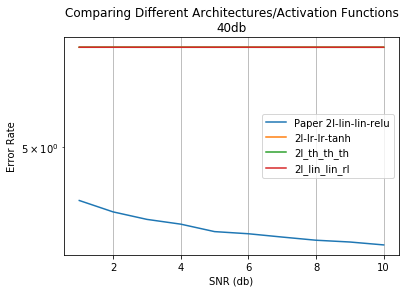

In [85]:
x = np.arange(1,11)
plt.figure()
plt.semilogy(x,history_rbf_40_local[:10])
plt.semilogy(x,history_rbf_2l_lr_lr_tanh_40_aws)
plt.semilogy(x,history_rbf_2l_th_th_th_40_aws)
plt.semilogy(x,history_rbf_2l_lin_lin_rl_40_aws)
plt.xlabel("SNR (db)")
plt.ylabel("Error Rate")
plt.title("Comparing Different Architectures/Activation Functions\n40db")
plt.grid()
plt.legend(["Paper 2l-lin-lin-relu", "2l-lr-lr-tanh", "2l_th_th_th", "2l_lin_lin_rl"])
plt.show()

##### Getting an  alternating model for AWGN

In [111]:
M = 8
Nc = 4
sigma = 0.22
transmitter, channel_sym_with_noise, \
    receiver, receiver_symbs \
    = get_paper_awgn_rx_and_tx_models(M, Nc, sigma)

##### Getting an  alternating model for RBF

In [105]:
M = 8
Nc = 4
sigma_m = 0.33
sigma_a = 1
transmitter, channel_sym_with_noise, \
    receiver, receiver_symbs \
    = get_paper_rbf_rx_and_tx_models(M, Nc, sigma_m, sigma_a)

#### Get Supervised AWGN performance across the SNR range of [-4,0.5,13]

In [34]:
# (8,8) tapered, n layers
t0 = time()
SNRs_db = np.arange(-4,13.5,0.5)
bler = np.empty(SNRs_db.size)

hl_act_f = keras.layers.advanced_activations.LeakyReLU()
hl_act_f.__name__ = 'leakyrelu'

# for i, ratio_db in enumerate(tqdm_notebook(SNRs_db, desc="1st loop")):
for i, ratio_db in enumerate(SNRs_db):
    print(f"ratio_db = {ratio_db}, i = {i+1}/{SNRs_db.size}", end="\r")
    t1 = time()
    bler[i] = get_complex_tapered_noise_bler_SNR(2**8, 2, ratio_db, \
                                                 './models/autoencoder8_8_tap_2l3.3856e-06.h5', \
                                                 test_data256, hl_act_f, \
                                                 "tanh", 2)
    print(f"\n{i}th loop took {time() - t1}s")
print(f"\nTook {time() - t0}")

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



0th loop took 51.436500549316406s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



1th loop took 51.906299352645874s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



2th loop took 51.930606842041016s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



3th loop took 52.61579132080078s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



4th loop took 52.799492597579956s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



5th loop took 53.136507511138916s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



6th loop took 53.56024432182312s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



7th loop took 53.93984580039978s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



8th loop took 53.98229122161865s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



9th loop took 54.836410999298096s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



10th loop took 55.04261589050293s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



11th loop took 55.47947311401367s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



12th loop took 55.967275857925415s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



13th loop took 56.49920988082886s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



14th loop took 57.087040424346924s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



15th loop took 57.46648573875427s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



16th loop took 57.54560446739197s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



17th loop took 57.83512878417969s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



18th loop took 58.547157764434814s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



19th loop took 58.95889925956726s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



20th loop took 59.41124773025513s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



21th loop took 60.30534219741821s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



22th loop took 60.44829869270325s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



23th loop took 60.9995174407959s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



24th loop took 60.82547616958618s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



25th loop took 62.30768156051636s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



26th loop took 61.84466576576233s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



27th loop took 63.05571937561035s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



28th loop took 67.72161793708801s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



29th loop took 64.11016845703125s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



30th loop took 63.89042639732361s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



31th loop took 65.06354212760925s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



32th loop took 65.12028694152832s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



33th loop took 65.20026087760925s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



34th loop took 66.1613438129425s

Took 2047.0448281764984


In [38]:
# autoencoder_awgn = bler
# np.save('./key_results/paper2/autoencoder_awgn.npy', autoencoder_awgn)

autoencoder_awgn = np.load('./key_results/paper2/autoencoder_awgn.npy')

#### Get Supervised RBF performance across the SNR range of [-4,0.5,13]

In [159]:
# autoencoder with rbf
# - trained at an SNR of 40
# - exactly the same architecture as the paper
# - training val_loss of 4.3824
t0 = time()
SNRs_db = np.arange(-4,13.5,0.5)
bler = np.empty(SNRs_db.size)

for i, ratio_db in enumerate(tqdm_notebook(SNRs_db, desc="1st loop")):
# for i, ratio_db in enumerate(SNRs_db):
    print(f"ratio_db = {ratio_db}, i = {i+1}/{SNRs_db.size}", end="\r")
    t1 = time()
    bler[i] = get_supervised_rbf_bler_SNR(8, 4, np.sqrt(0.5), ratio_db, \
                                          './models/autoencoder_rbf_sa40_4.3824.h5', \
                                          test_data256)

    
#     print(f"\n{i}th loop took {time() - t1}s")
print(f"\nTook {time() - t0}")

ratio_db = 13.0, i = 35/35

Took 1973.473479270935


In [156]:
t0 = time()
num_cores = multiprocessing.cpu_count()
print("num_cores = ", num_cores)

def tmp(SNR):
    return get_supervised_rbf_bler_SNR(8, 4, np.sqrt(0.5), SNR, \
                                          './models/autoencoder_rbf_sa40_4.3824.h5', \
                                          test_data256)

results = Parallel(n_jobs=num_cores)(delayed(tmp)(SNR) for SNR in SNRs_db)
print(f"Took {time()-t0}s")

num_cores =  4
Took 136.46156430244446s


In [158]:
results

[0.995525, 0.994975, 0.99555, 0.99547]

In [160]:
# From second run to check constistency
bler

array([0.995455, 0.995345, 0.9953  , 0.99551 , 0.994965, 0.994895,
       0.99479 , 0.9947  , 0.99411 , 0.99397 , 0.994045, 0.993545,
       0.99333 , 0.992605, 0.99238 , 0.991515, 0.990945, 0.990435,
       0.989335, 0.98868 , 0.987745, 0.98669 , 0.984195, 0.982355,
       0.98044 , 0.97794 , 0.97541 , 0.970705, 0.967605, 0.96307 ,
       0.95757 , 0.950065, 0.942965, 0.935495, 0.9258  ])

In [147]:
# From first run
bler

array([0.995415, 0.99536 , 0.995215, 0.995095])

In [162]:
# autoencoder_rbf_sa40_4_3824_bler = bler
# np.save('./key_results/paper2/autoencoder_rbf_sa40_4_3824_bler.npy', autoencoder_rbf_sa40_4_3824_bler)

autoencoder_rbf_sa40_4_3824_bler = np.load('./key_results/paper2/autoencoder_rbf_sa40_4_3824_bler.npy')

### Figure 6a - AWGN supervised vs unsupervised across a range of SNRs

In [39]:
# Dummy data for messing with the way the plot looks
x = np.arange(-4,13.5,0.5)
y = np.exp(-0.1*x**2)
z = y*0.8

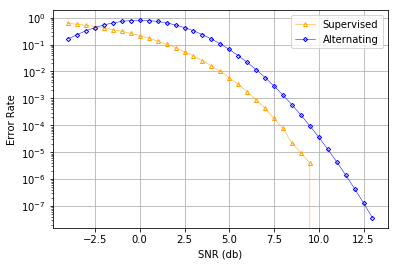

In [40]:
plt.figure()
plt.semilogy(x,autoencoder_awgn,'^-', color="orange", markerfacecolor='none', markersize=4, linewidth=0.5)
plt.semilogy(x,z,'D-', color="blue", markerfacecolor='none', markersize=3, linewidth=0.5)
plt.xlabel("SNR (db)")
plt.ylabel("Error Rate")
plt.grid()
plt.legend(["Supervised", "Alternating"])
plt.show()

### Figure 6b - RBF supervised vs unsupervised across a range of SNRs

In [ ]:
autoencoder_rbf_sa40_4_3824_bler

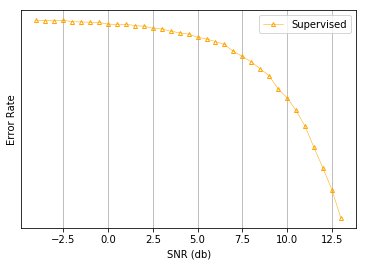

In [163]:
plt.figure()
plt.semilogy(x,autoencoder_rbf_sa40_4_3824_bler,'^-', color="orange", markerfacecolor='none', markersize=4, linewidth=0.5)
# plt.semilogy(x,z,'D-', color="blue", markerfacecolor='none', markersize=3, linewidth=0.5)
plt.xlabel("SNR (db)")
plt.ylabel("Error Rate")
plt.grid()
plt.legend(["Supervised"])
plt.show()

### Rician Fading

https://en.wikipedia.org/wiki/Rician_fading
<br>

https://www.gaussianwaves.com/tag/rician/

Also see the document in downloads about it.